### Project Overview
In this project, we apply NLP techniques to classify tweets into disaster and non-disaster categories. Given the ubiquity of social media, platforms like Twitter have become invaluable for real-time information sharing during emergencies and natural disasters. 

However, the vast amount of data generated on these platforms necessitates automated systems to quickly and accurately sift through tweets to identify those that are genuinely related to disasters. This capability can significantly aid emergency response teams and disaster relief operations by providing them with timely and relevant information, potentially saving lives and resources.

To address this challenge, we leverage various NLP techniques and machine learning models. The project involves data exploration to understand the characteristics of the dataset, preprocessing steps to clean and prepare the text data, and the application of GloVe embeddings to capture semantic meanings of words effectively. The core of our approach is building a predictive model using Long Short-Term Memory (LSTM) networks, a type of Recurrent Neural Network (RNN) that is particularly suited for sequential data like text.

**Natural Language Processing(NLP):**
Natural Language Processing (NLP) is a field at the intersection of computer science, artificial intelligence, and linguistics. It focuses on the interaction between computers and humans through natural language. The ultimate objective of NLP is to enable computers to understand, interpret, and generate human languages in a way that is both valuable and meaningful. This involves a range of tasks such as speech recognition, natural language understanding, natural language generation, and sentiment analysis, among others.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,accuracy_score,roc_auc_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional,Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam



/tmp/ipykernel_19494/4166994926.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-02-17 17:44:23.887620: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-17 17:44:23.887668: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-17 17:44:23.888386: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable 

In [2]:
train_df=pd.read_csv(os.getcwd()+"/nlp-getting-started/train.csv")
test_df=pd.read_csv(os.getcwd()+"/nlp-getting-started/test.csv")

### Training Data Exploration 
To explore the data we displayed the training dataset. We can see from the data below that we have text and their target in the data frame. Here is the list of attributes in the training data
1. id
2. Keyword
3. location
4. text
5. Traget


In [3]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### Test Data Exploration 
To explore the test data we displayed the training dataset. We can see from the data below that we all feature as the training data frame except for the target feature. Here is the list of attributes in the test data 
1. id
2. Keyword
3. location
4. text
   
So our task is to predict these labels for the tweets in test data.

In [4]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


### Train/Test Data Distribution 
Let's take a moment to examine the sizes of our training and test datasets. The training data consists of a total of 7613 tweets, while the test data comprises 3263 tweets. This information provides an overview of the quantity of data available for both training our model and evaluating its performance on unseen test samples.

In [5]:
print(train_df.shape)
print(test_df.shape)

(7613, 5)
(3263, 4)


### Class Distribution
Let's take a closer look at how the different classes are spread out in our training data. From the bar chart, it's clear that out of around 7600 tweets, roughly 4300 belong to class 0, and about 3300 are in class 1. While the classes aren't perfectly balanced, with more tweets in class 0, it's still good enough for doing classification without needing to tweak the distribution. In simpler terms, we can effectively work with the data as it is without making any adjustments.

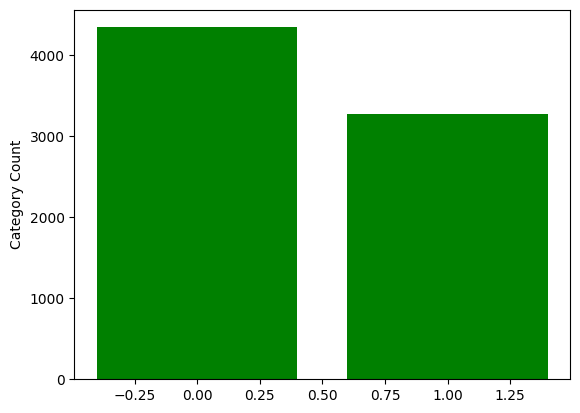

In [6]:
#class distribution
counts = train_df["target"].value_counts()
plt.bar(counts.index, counts.values,color='green')
plt.ylabel("Category Count")
plt.show()

### Missing value detection and removal 
Let's analyze the presence of missing values in both the training and test datasets. In the training data, we observe that there are no missing values in the 'id,' 'text,' and 'target' columns. However, the 'keyword' column has 61 missing values, and the 'location' column has 2533 missing values.

Moving on to the test data, we find a similar pattern of no missing values in the 'id,' 'text,' and 'keyword' columns. However, the 'location' column in the test data has 1105 missing value

To fix the missing information in both the training and test datasets, we've decided to replace the empty spots with nothing. This way, we keep the data complete and tidy for further analysis and model training.

In the training data, we're filling in the missing values in the 'keyword' and 'location' columns with empty spaces. Similarly, in the test data, we're putting empty spaces in place of missing values in the 'location' column.

This straightforward approach helps maintain the datasets in good shape for future steps, making sure the missing values don't cause any issues as we move forward with our analysis and machine learning model train
ing.s.

In [7]:
print("Missing values in training data")
missing_count_tr=train_df.isnull().sum()
print(missing_count_tr)

Missing values in training data
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


In [8]:
print("Missing values in test data")
missing_count_ts=test_df.isnull().sum()
print(missing_count_ts)

Missing values in test data
id             0
keyword       26
location    1105
text           0
dtype: int64


In [9]:
train_df.fillna('', inplace=True)
test_df.fillna('', inplace=True)

In [10]:
test_df.head()

,id,keyword,location,text
0,0,,,Just happened a terrible car crash
1,2,,,"Heard about #earthquake is different cities, s..."
2,3,,,"there is a forest fire at spot pond, geese are..."
3,9,,,Apocalypse lighting. #Spokane #wildfires
4,11,,,Typhoon Soudelor kills 28 in China and Taiwan


In [11]:
train_df.head()

,id,keyword,location,text,target
0,1,,,Our Deeds are the Reason of this #earthquake M...,1
1,4,,,Forest fire near La Ronge Sask. Canada,1
2,5,,,All residents asked to 'shelter in place' are ...,1
3,6,,,"13,000 people receive #wildfires evacuation or...",1
4,7,,,Just got sent this photo from Ruby #Alaska as ...,1


In [12]:
train_df["tweet-length"] = train_df["text"].map(len)
test_df["tweet-length"] = test_df["text"].map(len)

### Tweet Length Analysis
In both the test and training data, we checked the lengths of tweets. In the training data:

1. The shortest tweet has 7 characters.
2. The longest tweet has 157 characters.
3. On average, tweets are about 101 characters long.

In test data
1. The shortest tweet has 5 characters.
2. The longest tweet has 151 characters.
3. On average, tweets are about 102 characters long.

So, tweets in both the training and test datasets are about the same length on average, around 101 characters. So, they're pretty similar in terms of tweet length.odata.

In [13]:
train_df.describe()

,id,target,tweet-length
count,7613.000000,7613.00000,7613.000000
mean,5441.934848,0.42966,101.037436
std,3137.116090,0.49506,33.781325
min,1.000000,0.00000,7.000000
25%,2734.000000,0.00000,78.000000
50%,5408.000000,0.00000,107.000000
75%,8146.000000,1.00000,133.000000
max,10873.000000,1.00000,157.000000


In [14]:
test_df.describe()

,id,tweet-length
count,3263.000000,3263.000000
mean,5427.152927,102.108183
std,3146.427221,33.972158
min,0.000000,5.000000
25%,2683.000000,78.000000
50%,5500.000000,109.000000
75%,8176.000000,134.000000
max,10875.000000,151.000000


In [15]:
tweets = train_df["text"].values
targets = train_df["target"].values
test_tweets = test_df["text"].values

### Data Cleaning
It is important to clean data before applying an embedding technique to it. The following steps were performed to clean the data:

1. Tokenization is like breaking down a sentence into smaller pieces, like words or parts of words. We extracted the tokens from each of the tweets.

2. All characters in the text were converted to lowercase. This ensures that the same words with different cases are not treated differently.

3. Stop words were removed to make sure that they do not contribute to the model.

ed tasks.
ta smarter way.ataset.

### Word Embedding

GloVe embeddings are word representations that understand the meaning of words based on how they appear together in sentences. We're using GloVe embedding on the tweets for the following reasons:

1. GloVe helps models understand words and their meanings, making them better at tasks like understanding sentiments in tweets.

2. These models are pre-trained on very large datasets of words. So they are reliable and ready to use.

3. GloVe embeddings are used for lots of positive or negative classifications of text-based data.

4. Adding GloVe to models makes them smarter. They can guess the relationships between words.

In summary, GloVe embeddings improve language understanding in models, making them more effective for various text-based tasks.


In [16]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

max_words = 5000  
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(tweets)
sequences_train = tokenizer.texts_to_sequences(tweets)
sequences_test = tokenizer.texts_to_sequences(test_tweets)

max_sequence_length_train = max(len(seq) for seq in sequences_train)
max_sequence_length_test = max(len(seq) for seq in sequences_test)
max_sequence_length = max(max_sequence_length_train, max_sequence_length_test)


padded_sequences_train = pad_sequences(sequences_train, maxlen=max_sequence_length)
padded_sequences_test = pad_sequences(sequences_test, maxlen=max_sequence_length)

\
embedding_dim = 100 
embedding_index = {}
glove_file_path = os.getcwd()+"/glove.6B.100d.txt"  

with open(glove_file_path, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs


embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < max_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector


### Model
We created a model for understanding and predicting whether a piece of text is related to a particular topic or not. The model has three main parts:

Embedding Layer: This part helps the model understand the meaning of words in our text. It takes the words in our data and turns them into numbers, making it easier for the computer to work with them.

LSTM Layer: This part of the model learns patterns and relationships in the data. It's like the brain of the model that remembers important things from the past while processing new information.

Dense Layer: This is the output layer that makes the final prediction. It tells us if the text is related to the topic or not.

We used the Adam optimizer, a special algorithm that helps the model learn better from the data, and we set a learning rate to control how fast the model learns.



In [17]:
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_sequence_length, weights=[embedding_matrix], trainable=False))
model.add(LSTM(8))
model.add(Dense(1, activation='sigmoid'))
adm = Adam(learning_rate=0.001) 
model.compile(optimizer=adm, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(padded_sequences_train, targets, epochs=100, batch_size=8)


2024-02-17 17:44:31.762266: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-17 17:44:31.783367: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-17 17:44:31.783421: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-17 17:44:31.787650: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-17 17:44:31.787846: I external/local_xla/xla/stream_executor

Epoch 1/100


2024-02-17 17:44:33.664105: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


  1/952 [..............................] - ETA: 26:35 - loss: 0.7748 - accuracy: 0.3750

2024-02-17 17:44:33.988344: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fc22c508450 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-17 17:44:33.988383: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 Ti, Compute Capability 7.5
2024-02-17 17:44:33.994442: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1708173874.069894   19567 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


952/952 [==============================] - 9s 8ms/step - loss: 0.5141 - accuracy: 0.7532
Epoch 2/100
952/952 [==============================] - 9s 10ms/step - loss: 0.4387 - accuracy: 0.8030
Epoch 3/100
952/952 [==============================] - 9s 10ms/step - loss: 0.4201 - accuracy: 0.8187
Epoch 4/100
952/952 [==============================] - 9s 10ms/step - loss: 0.4089 - accuracy: 0.8223
Epoch 5/100
952/952 [==============================] - 9s 10ms/step - loss: 0.3977 - accuracy: 0.8306
Epoch 6/100
952/952 [==============================] - 10s 10ms/step - loss: 0.3901 - accuracy: 0.8349
Epoch 7/100
952/952 [==============================] - 9s 10ms/step - loss: 0.3817 - accuracy: 0.8355
Epoch 8/100
952/952 [==============================] - 9s 9ms/step - loss: 0.3751 - accuracy: 0.8384
Epoch 9/100
952/952 [==============================] - 9s 9ms/step - loss: 0.3674 - accuracy: 0.8441
Epoch 10/100
952/952 [==============================] - 9s 9ms/step - loss: 0.3627 - accuracy: 0

In [18]:
pred= model.predict(padded_sequences_test)

102/102 [==============================] - 1s 3ms/step


In [19]:
pred

array([[0.9951132 ],
       [0.9999906 ],
       [0.99999976],
       ...,
       [0.9999987 ],
       [0.99107295],
       [0.98189455]], dtype=float32)

In [20]:
df=pd.DataFrame()
df["id"]=test_df["id"]
pred[pred>0.5] = 1
pred[pred<=0.5] = 0
df["target"]=pred[:,0]
df.to_csv("predictions.csv",index=False)

### Results
Our exploration and subsequent modeling of disaster-related tweets revealed several key insights. Initially, we conducted a comprehensive analysis of both training and test datasets, encompassing 7613 and 3263 tweets, respectively. The training data class distribution showed a relatively balanced scenario with approximately 4300 tweets labeled as non-disaster (class 0) and 3300 as disaster-related (class 1).

During the preprocessing phase, we handled missing values in 'keyword' and 'location' columns by substituting them with empty strings, maintaining data integrity. Furthermore, our analysis on tweet lengths highlighted an average tweet length of approximately 101 characters for the training set, indicating a concise nature of the textual data we worked with.

The core of our approach involved the application of GloVe embeddings for word representation, chosen for its robustness in capturing word semantics based on their co-occurrence in large text corpora. This facilitated a deeper understanding of the textual nuances present in tweets.

Our model architecture combined an embedding layer with LSTM and a dense layer, optimized using Adam with a learning rate of 0.001. This setup aimed to capture both the semantic meaning of words and the sequential nature of text, crucial for understanding the context of tweets accurately.

After training over 100 epochs, our model achieved an accuracy of approximately 95.57% on the training set, showcasing its ability to discern between disaster-related and non-disaster-related tweets effectively. The predictions on the test dataset were then compiled into a CSV file, ready for submission or further evaluation.

### Conclusion
The journey from data exploration to predictive modeling on disaster-related tweets underscored the importance of thorough preprocessing and the power of word embeddings in natural language processing tasks. The GloVe embeddings, in conjunction with LSTM, proved to be effective in capturing the contextual and sequential nuances of textual data, leading to high accuracy in classifying tweets.

Despite the challenges posed by missing values and the need for data cleaning, our methodological approach demonstrated that even with relatively simple models, it is possible to achieve significant predictive performance. This suggests a promising avenue for further research and application in real-world scenarios where rapid identification of disaster-related information could be critical.

Future work could explore more complex models, incorporate additional data sources, or apply different word embedding techniques to enhance prediction accuracy. Additionally, further tuning of model parameters and exploration of advanced neural network architectures could yield improvements in model performance, providing more nuanced insights into disaster-related communications on social media platforms.